In [ ]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
import optax
import tqdm
from functools import partial

backend = "cpu"

In [ ]:
class SpectralConv1d(nnx.Module):
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes: int

    def __init__(
        self, in_channels: int, out_channels: int, modes: int, *, rngs=nnx.Rngs
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        key1 = rngs.params()
        key2 = rngs.params()
        self.modes = modes
        scale = 1.0 / (self.in_channels * self.out_channels * self.modes)
        self.real_weights = nnx.Param(
            jax.random.uniform(
                key1,
                (self.in_channels, self.out_channels, self.modes),
                minval=-scale,
                maxval=scale,
            )
        )
        self.imag_weights = nnx.Param(
            jax.random.uniform(
                key2,
                (self.in_channels, self.out_channels, self.modes),
                minval=-scale,
                maxval=scale,
            )
        )

    @nnx.jit
    def complex_mult1d(self, x: jax.Array, y: jax.Array) -> jax.Array:
        return jnp.einsum("bcM,coM->boM", x, y)

    def __call__(self, x: jax.Array):
        batch_size, channels, spatial_points = x.shape
        x_hat = jnp.fft.rfft(x, axis=-1)
        x_hat_under_modes = x_hat[:, :, : self.modes]
        weights = self.real_weights + 1j * self.imag_weights
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)
        # jax.debug.print("{out_hat_under_modes}", out_hat_under_modes=out_hat_under_modes.shape)
        out_hat = jnp.zeros(
            (batch_size, self.out_channels, x_hat.shape[-1]), dtype=x_hat.dtype
        )
        out_hat = out_hat.at[:, :, : self.modes].set(out_hat_under_modes)
        out = jnp.fft.irfft(out_hat, n=spatial_points, axis=-1)
        return out


class FNOBlock1d(nnx.Module):
    """A single block of the Fourier Neural Operator."""

    spectral_conv: SpectralConv1d
    bypass_conv: nnx.Conv
    activation: Callable

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        modes: int,
        activation: Callable,
        *,
        rngs=nnx.Rngs
    ):
        self.spectral_conv = SpectralConv1d(in_channels, out_channels, modes, rngs=rngs)
        self.bypass_conv = nnx.Conv(
            in_features=in_channels,
            out_features=out_channels,
            kernel_size=(1,),
            rngs=rngs,
        )
        self.activation = activation

    def __call__(self, x: jax.Array):
        # x shape: (batch_size, channels, spatial_points)
        # For bypass conv, we need to transpose to (batch_size, spatial_points, channels)
        x_transposed = x.transpose(0, 2, 1)  # (batch_size, spatial_points, channels)
        bypass_out = self.bypass_conv(
            x_transposed
        )  # (batch_size, spatial_points, out_channels)
        bypass_out = bypass_out.transpose(
            0, 2, 1
        )  # (batch_size, out_channels, spatial_points)

        return self.activation(self.spectral_conv(x) + bypass_out)


class FNO1d(nnx.Module):
    """Fourier Neural Operator for 1D data."""

    lifting_function: nnx.Conv
    projection_function: nnx.Conv
    fno_blocks: list[FNOBlock1d]
    rngs: nnx.Rngs

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden_channels: int,
        modes: int,
        num_blocks: int,
        activation: Callable,
        *,
        rngs=nnx.Rngs
    ):
        self.rngs = rngs
        # self.lifting_function = MLP(n_features=in_channels, n_hidden=hidden_channels,
        #                             n_layers=3, n_output=hidden_channels, dropout=0.1, rngs=rngs)
        # # Projection function to map back to output space
        # self.projection_function = MLP(n_features=hidden_channels, n_hidden=hidden_channels,
        #                                n_layers=3, n_output=out_channels, dropout=0.1, rngs=rngs)
        self.lifting_function = nnx.Conv(
            in_features=in_channels,
            out_features=hidden_channels,
            kernel_size=(1,),
            rngs=rngs,
        )
        self.projection_function = nnx.Conv(
            in_features=hidden_channels,
            out_features=out_channels,
            kernel_size=(1,),
            rngs=rngs,
        )
        self.fno_blocks = [
            FNOBlock1d(hidden_channels, hidden_channels, modes, activation, rngs=rngs)
            for _ in range(num_blocks)
        ]

    @nnx.jit
    def _forward_batched(self, x: jax.Array):
        """Forward pass for batched input (batch_size, spatial_points, channels)."""
        x = self.lifting_function(
            x
        )  # Shape: (batch_size, spatial_points, hidden_channels)
        x = x.transpose(0, 2, 1)  # Shape: (batch_size, hidden_channels, spatial_points)
        for block in self.fno_blocks:
            x = block(x)
        x = x.transpose(0, 2, 1)  # Shape: (batch_size, spatial_points, hidden_channels)
        x = self.projection_function(
            x
        )  # Shape: (batch_size, spatial_points, out_channels)
        return x

    @nnx.jit
    def _forward_single(self, x: jax.Array):
        """Forward pass for single input (spatial_points, channels)."""
        x = x[None, ...]  # Add batch dimension: (1, spatial_points, channels)
        x = self._forward_batched(x)
        return x[0]  # Remove batch dimension: (spatial_points, out_channels)

    def __call__(self, x: jax.Array):
        """Main forward pass - optimized for batched inputs (most common case)."""
        if len(x.shape) == 3:
            return self._forward_batched(x)
        else:
            return self._forward_single(x)

    @nnx.jit
    def call_batched(self, x: jax.Array):
        """Explicitly call with batched input - no shape checking overhead."""
        return self._forward_batched(x)

    @nnx.jit
    def call_single(self, x: jax.Array):
        """Explicitly call with single input - no shape checking overhead."""
        return self._forward_single(x)

In [ ]:
RNGS = nnx.Rngs(params=21)
fno1 = FNO1d(2, 1, 32, 16, 4, jax.nn.gelu, rngs=RNGS)


@nnx.jit
def loss_fn(model: FNO1d, x: jax.Array, y: jax.Array):
    y_pred = model.call_single(x)
    return jnp.mean((y_pred - y) ** 2)


grads = nnx.grad(loss_fn, argnums=0)


@nnx.jit(static_argnames=("grad_fun", "loss_fn"))
def grad_and_update(
    optimizer: nnx.Optimizer,
    model: FNO1d,
    grad_fun: Callable,
    loss_fn: Callable,
    x: jax.Array,
    y: jax.Array,
):
    grads = grad_fun(model, x, y)
    loss_value = loss_fn(model, x, y)
    optimizer.update(model, grads)
    return loss_value


state1 = nnx.Optimizer(fno1, optax.adam(0.5 * 1e-3), wrt=nnx.Param)

In [ ]:
x = jax.random.uniform(RNGS.params(), (4, 102, 2))
y = jax.random.uniform(RNGS.params(), (4, 102, 1))
n_full = x.shape[0]
EPOCHS = 100

loss_list = []
for _ in tqdm.tqdm(range(EPOCHS)):
    loss_epoch = 0
    for j in range(n_full):
        loss = grad_and_update(state1, fno1, grads, loss_fn, x[j, :, :], y[j, :, :])
        loss_epoch += loss
    loss_list.append(loss_epoch / (n_full))

100%|██████████| 100/100 [00:02<00:00, 42.23it/s]


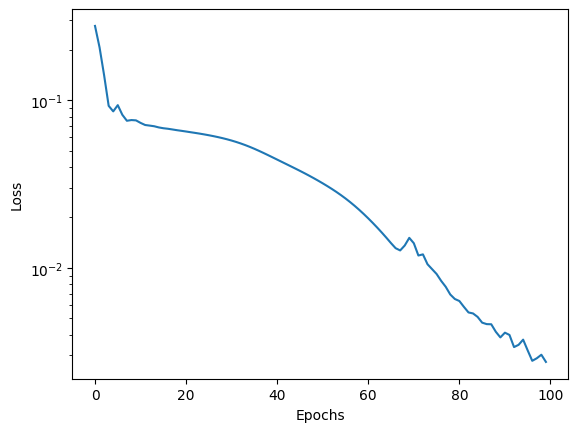

In [ ]:
plt.plot(loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.semilogy()
plt.show()

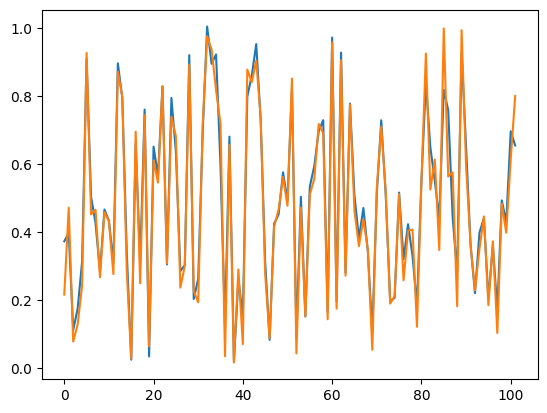

In [ ]:
results = fno1.call_single(x[0, :, :])
plt.plot(results)
plt.plot(y[0, :, :])
plt.show()